In [48]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import MySignal as sig

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
class StandardizedRollingGrowthDiff(sig.Indicator):
    def __init__(self, series_names, weights_dict, world=['USA', 'CAN', 'AUS', 'GBR', 'CHE'], n_periods=130):
        super(StandardizedRollingGrowthDiff, self).__init__(series_names)
        self.weights_dict = weights_dict
        self.world = world
        
        for series_name in series_names:
            self.series_dict[series_name] = sig.standardize(self.series_dict[series_name].pct_change() \
            .rolling(n_periods, n_periods).apply(lambda x: (1+x).prod()-1, raw=True))
            
            self.series_dict[series_name]['world'] = self.series_dict[series_name].mean(axis=1)
            
        for series_name in series_names:
            for country in self.world:
                self.series_dict[series_name][country] -= self.series_dict[series_name]['world']

    def combine_series(self, series_up_to_date):
        weighted_values = {}
        for series_name in series_up_to_date.keys():
            weighted_values[series_name] = self.weights_dict[series_name] * series_up_to_date[series_name].iloc[-1]
        return sum(weighted_values.values()) / sum(np.abs(list(self.weights_dict.values())))
    
    def plot_indicator_returns_diff(self, countries, beg_date, end_date, figsize=None):
        values = self.get_values(countries, beg_date, end_date)
        bond_returns = sig.get_bond_returns(self.world, beg_date, end_date)
        bond_returns['world'] = bond_returns.mean(axis=1)
        
        annualized_bond_returns = ((1+bond_returns)**261)-1

        for country in countries:
            print('Preparing {} plot'.format(country))
            fig, ax1 = plt.subplots(figsize=figsize)
            ax2 = ax1.twinx()

            ax1.plot(values[country].to_timestamp(), color='black', label='Indicator')
            ax1.set_ylabel('Value')
            ax1.legend(loc=2)

            ax2.plot(100*(annualized_bond_returns[country]-annualized_bond_returns['world']).to_timestamp(),
                     color='blue', label='Bond Returns')
            ax2.set_ylabel('Annualized Returns (%)')
            ax2.legend(loc=1)

            plt.xlabel('Date')

            plt.title('{} Indicators vs Bond Alpha Returns'.format(country))
            plt.show()

In [50]:
countries=['USA']
world_countries = ['USA', 'CAN', 'AUS', 'GBR', 'CHE']
beg_date, end_date = ('1995-01-01', '2005-12-31')

Preparing USA plot


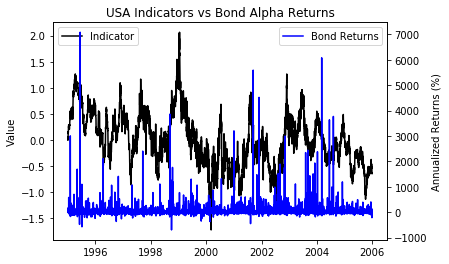

In [51]:
equities_growth_diff = StandardizedRollingGrowthDiff(series_names = ['EquityPrices'],
                                                    weights_dict = {'EquityPrices': 1})
equities_growth_diff.plot_indicator_returns_diff(countries, beg_date, end_date)

In [52]:
class SigmoidNormalizerDiff(sig.Signal):
    def __init__(self, indicators_dict, weights_dict, world=['USA', 'CAN', 'AUS', 'GBR', 'CHE'],
                 sigmoid_scaling_factor=1.0, beta_overlay=0):
        super(SigmoidNormalizerDiff, self).__init__(indicators_dict)
        self.weights_dict = weights_dict
        self.sigmoid_scaling_factor = sigmoid_scaling_factor
        self.world = world
        self.beta_overlay = beta_overlay
        
    def combine_indicators_values(self, indicators_values):
        weighted_values = {}
        for indicator_name in indicators_values.keys():
            weighted_values[indicator_name] = (self.weights_dict[indicator_name] *
                                               sig.aug_sigmoid(indicators_values[indicator_name],
                                                           scaling_factor=self.sigmoid_scaling_factor))
        return sum(weighted_values.values()) / sum(np.abs(list(self.weights_dict.values())))
    
    def send(self, country, date):
        world_signals = {}
        for world_country in self.world:
            world_signals[world_country] = self.send_one_country(world_country, date)
        signals_sum = sum(world_signals.values())
        
        adjusted_signals = {}
        for world_country in self.world:
            adjusted_signals[world_country] = world_signals[world_country] -signals_sum/len(self.world)
        
        max_signal = np.max(np.abs(list(adjusted_signals.values())))
        normalized_signals = {}
        if max_signal > 1:
            for world_country in self.world:
                normalized_signals[world_country] = adjusted_signals[world_country]/max_signal
        else:
            normalized_signals = adjusted_signals
            
        beta_adjusted_signals = {}
        beta = self.beta_overlay
        alpha = 1-self.beta_overlay
        for world_country in self.world:
            beta_adjusted_signals[world_country] = beta + alpha * normalized_signals[world_country]
                
        return beta_adjusted_signals[country]

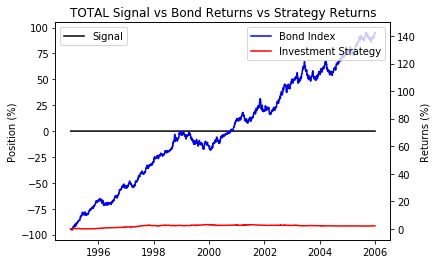

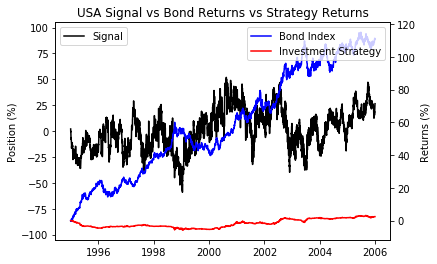

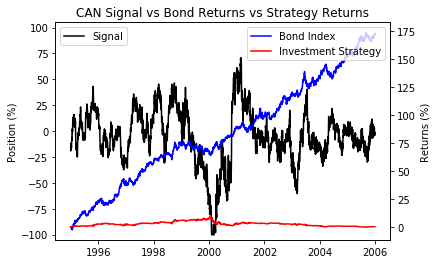

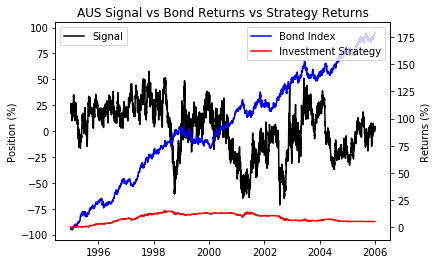

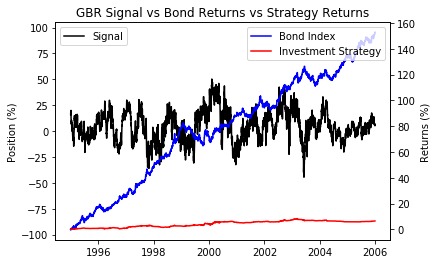

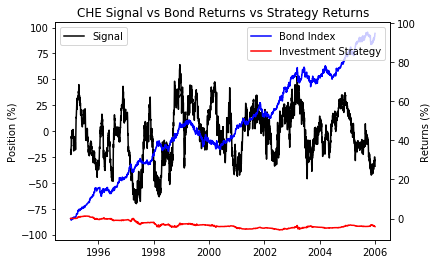

,USA,CAN,AUS,GBR,CHE,TOTAL
Sharpe Ratio,-20.8889,-14.909,-15.1184,-35.9727,-14.479,-53.68
Total Return (%),0.157689,0.00256463,0.337368,0.409604,-0.273507,0.132559
Excess Return (%),-4.10467,-4.40217,-5.10284,-4.837,-2.3215,-4.12871
Maximum Drawdown (%),-5.68519,-8.60405,-8.86464,-2.35629,-7.01152,-1.13193
R-Squared,0.00127057,9.24059e-05,0.000324379,2.78677e-06,0.000628747,3.79271e-05
Volatility,0.1965,0.295268,0.337525,0.134463,0.160336,0.0769134


In [54]:
equities_growth_diff_signal = SigmoidNormalizerDiff(indicators_dict={'equities_diff': equities_growth_diff},
                                                    weights_dict={'equities_diff': -1})
equities_growth_diff_signal.plot_signal_index_returns(world_countries, beg_date, end_date)
equities_growth_diff_signal.get_metrics(world_countries, beg_date, end_date)

Preparing USA plot


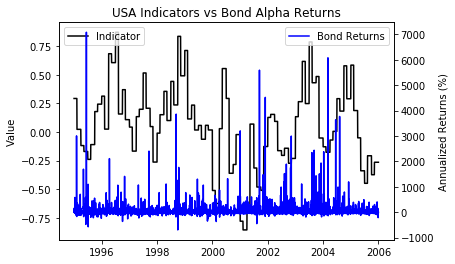

In [55]:
gdp_growth_diff = StandardizedRollingGrowthDiff(series_names = ['GDP/Real'],
                                                    weights_dict = {'GDP/Real': 1})
gdp_growth_diff.plot_indicator_returns_diff(countries, beg_date, end_date)

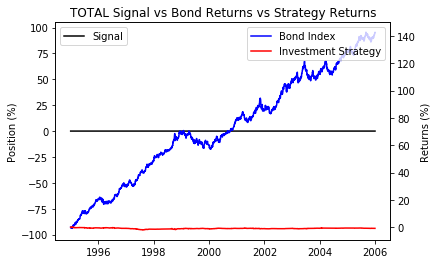

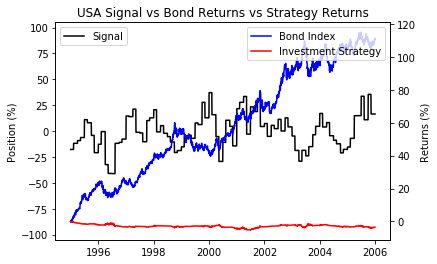

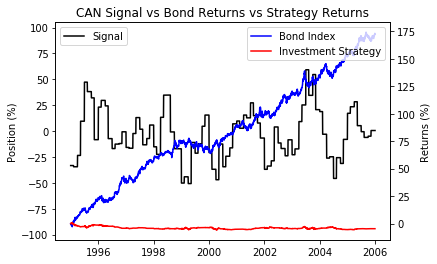

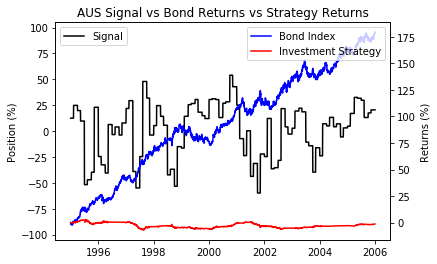

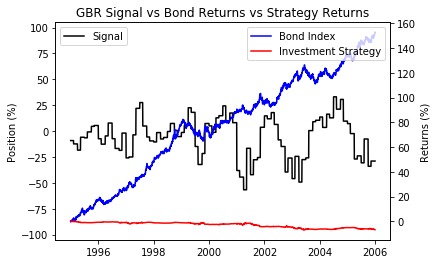

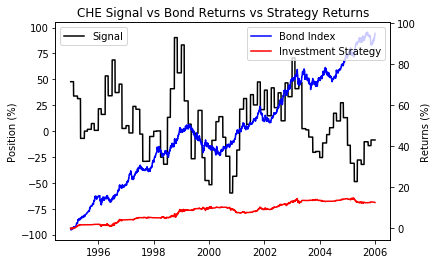

,USA,CAN,AUS,GBR,CHE,TOTAL
Sharpe Ratio,-21.9485,-20.9555,-13.0781,-37.1439,-5.94052,-52.8002
Total Return (%),-0.231896,-0.308999,-0.0894756,-0.453767,0.771631,-0.0566328
Excess Return (%),-4.47774,-4.7001,-5.50667,-5.65543,-1.30184,-4.3099
Maximum Drawdown (%),-5.19394,-6.64411,-9.26412,-6.99059,-2.91455,-2.10686
R-Squared,0.00123738,0.0001469,0.000347197,0.000471118,0.0016928,4.01935e-05
Volatility,0.204011,0.22429,0.421061,0.152258,0.219146,0.0816265


In [56]:
gdp_growth_diff_signal = SigmoidNormalizerDiff(indicators_dict={'gdp_diff': gdp_growth_diff},
                                                    weights_dict={'gdp_diff': -1})
gdp_growth_diff_signal.plot_signal_index_returns(world_countries, beg_date, end_date)
gdp_growth_diff_signal.get_metrics(world_countries, beg_date, end_date)

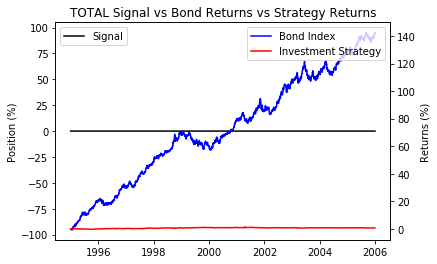

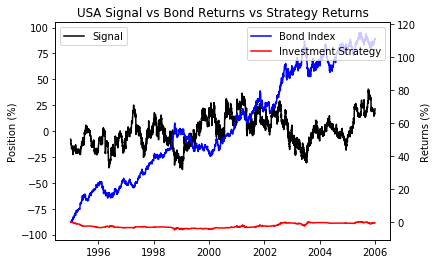

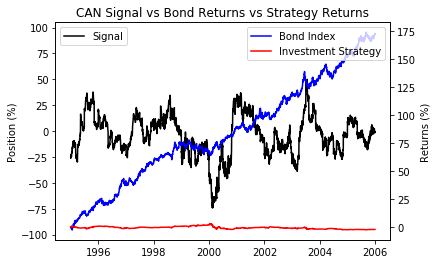

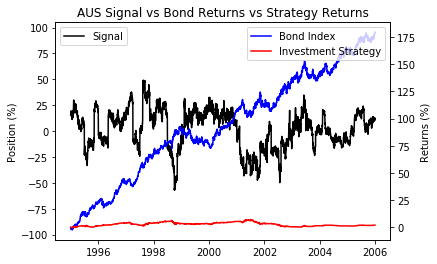

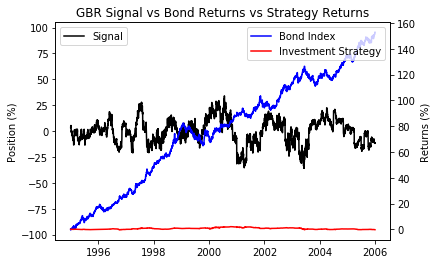

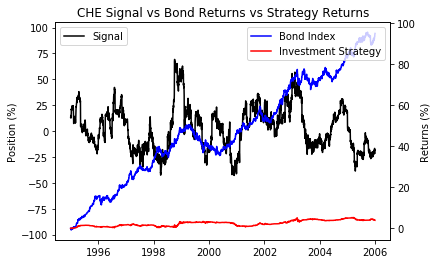

,USA,CAN,AUS,GBR,CHE,TOTAL
Sharpe Ratio,-27.5059,-24.3594,-20.0353,-57.1324,-12.8173,-67.8458
Total Return (%),-0.0345711,-0.1581,0.130899,-0.0187359,0.24885,0.0374841
Excess Return (%),-4.28878,-4.5558,-5.29818,-5.24304,-1.8119,-4.21976
Maximum Drawdown (%),-4.81506,-5.23219,-6.39787,-2.37414,-2.51141,-0.637738
R-Squared,0.00179643,4.10198e-07,3.44893e-06,0.000261604,0.00186808,6.32475e-05
Volatility,0.155922,0.187024,0.264442,0.0917701,0.141363,0.0621963


In [57]:
equities_gdp_growth_diff_signal = SigmoidNormalizerDiff(indicators_dict={'gdp_diff': gdp_growth_diff,
                                                                         'equities_diff': equities_growth_diff},
                                                    weights_dict={'gdp_diff': -1,
                                                                  'equities_diff': -1})
equities_gdp_growth_diff_signal.plot_signal_index_returns(world_countries, beg_date, end_date)
equities_gdp_growth_diff_signal.get_metrics(world_countries, beg_date, end_date)

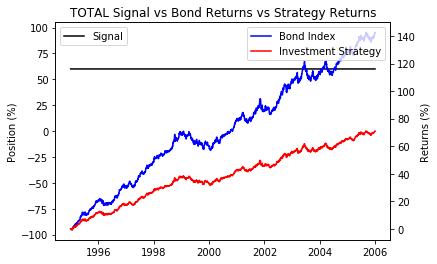

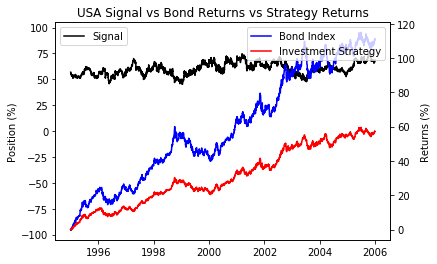

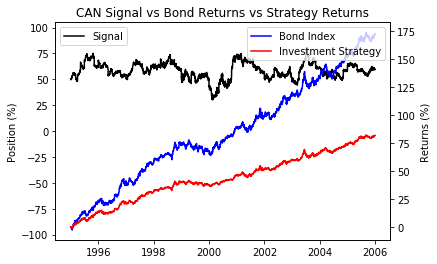

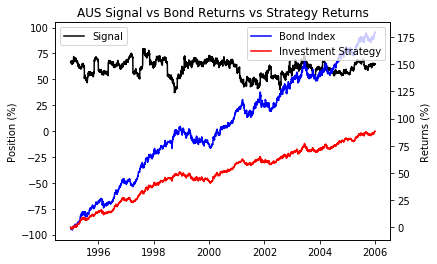

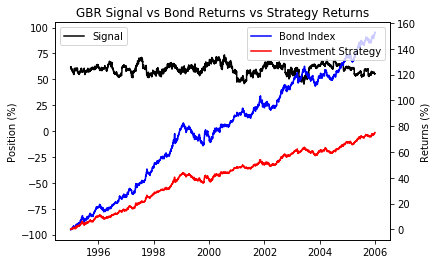

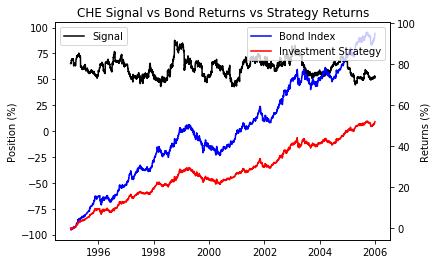

,USA,CAN,AUS,GBR,CHE,TOTAL
Sharpe Ratio,-1.52594,-0.820355,-0.792683,-1.97628,1.261,-2.03573
Total Return (%),2.97686,3.95671,4.19891,3.70546,2.75211,3.54695
Excess Return (%),-1.40492,-0.621459,-1.44981,-1.71264,0.631431,-0.858997
Maximum Drawdown (%),-7.57461,-4.5481,-6.5296,-5.6933,-6.21385,-4.72043
R-Squared,0.00296482,0.00271204,0.00178402,0.000822217,0.00675198,0.056476
Volatility,0.920694,0.757548,1.82899,0.866596,0.500739,0.421961


In [58]:
beta_equities_gdp_growth_diff_signal = SigmoidNormalizerDiff(indicators_dict={'gdp_diff': gdp_growth_diff,
                                                                         'equities_diff': equities_growth_diff},
                                                    weights_dict={'gdp_diff': -1,
                                                                  'equities_diff': -1},
                                                            beta_overlay=0.6)
beta_equities_gdp_growth_diff_signal.plot_signal_index_returns(world_countries, beg_date, end_date)
beta_equities_gdp_growth_diff_signal.get_metrics(world_countries, beg_date, end_date)

In [61]:
df = pd.DataFrame(index=[pd.Period('2010Q1'), pd.Period('2010Q2'), pd.Period('2010Q3'), pd.Period('2010Q4')],
                  data={'col1': [1, 2, 3, 4]})
df

,col1
2010Q1,1
2010Q2,2
2010Q3,3
2010Q4,4


In [62]:
df = df.resample('1M').ffill()
df

,col1
2010-01,1
2010-02,1
2010-03,1
2010-04,2
2010-05,2
2010-06,2
2010-07,3
2010-08,3
2010-09,3
2010-10,4
